## Fig. 2. QIF network with TAH rule produces stable propagation of synfire chain.
### A.
 Spike rastar plot. Synchronized bursts sequentially propagate in the network.
### B, C.
FREs (solid line) coincides with numerical simulation (dashed line) of the network.  
B firing rate. C membrane potential.

In [ ]:
from scipy.integrate import solve_ivp
from scipy.optimize import root
from scipy.linalg import eig
from scipy.interpolate import interp1d
import os
from QIFNetwork import *
from FREs import *

In [ ]:
# config for plotting. copied from 修論
config = {
        'font.family' : 'sans-serif',
        'font.size' : 12.0,
        'xtick.direction' : 'in',
        'ytick.direction' : 'in',
        'axes.xmargin' : 0.1,
        'axes.ymargin' : 0.11,
        'axes.linewidth' : 1.0,
        'axes.titlelocation' : 'left',
        'lines.linewidth' : 0.7,
        'legend.fancybox' : False,
        'legend.loc' : 'upper right'
    }
plt.rcParams.update(config)
# label = ['(' + chr(ord("a")+i) + ')' for i in range(26)]
savedir = 'fig2/'
os.makedirs(savedir, exist_ok=True)

In [5]:
# parameters
J1 = 15; J2 = 15; eta = -5; delta = 1.0
P = 8

In [6]:
t0 = 0; t1 = 100
t_eval = np.linspace(t0, t1, 10000)

# compute fixed points
focus = root(lambda y : fre_single(0, y, J2, eta, delta), [[1, 0]]).x
node = root(lambda y : fre_single(0, y, J2, eta, delta), [[0, -2]]).x
saddle = root(lambda y : fre_single(0, y, J2, eta, delta), [[0.5, -0.5]]).x

In [8]:
# simulation of FRE
t0 = -0.1; t1 = 1.0
t_uniform = np.linspace(t0, t1, 2**10, dtype='float64')

y0 = np.repeat(node, P)
# y0[0] += 0; y0[P] += 10.0

tau = 1e-4                                    # 標準偏差 (s)
amp = 10.0/tau
i_ext = lambda t: np.where(
    (t>0) & (t<=tau),
    amp * np.eye(P)[0],
    np.zeros(P)
)
# amp = 10.0 / (np.sqrt(2*np.pi) * tau)         # 面積を 10 に合わせる

# i_ext = lambda t: np.concatenate(
#     ([amp * np.exp(-0.5 * (t / tau)**2)],     # r_0 だけ
#      np.zeros(P-1))
# )

# i_ext = lambda t: np.sin(2 * np.pi * t / 40.0) * amp * np.ones(P) 
sol = solve_ivp(fre_seq, (t0, t1), y0, t_eval=t_uniform, args = (J1, J2, eta,delta, P, i_ext), max_step = tau/10) # NOTE : r_k = y[k], v_k = y[k+P] 

# interpolator =interp1d(sol.t, sol.y, kind = 'cubic')
# y_uniform = interpolator(t_uniform)
# plt.imshow(y_uniform[:P], aspect='auto', cmap='viridis', extent=[t0, t1, P, 0], vmin = 0, vmax = 50)
# plt.xlabel('time')
# plt.ylabel('# group')
# plt.title('sequential activity - theory')
# plt.show()

# plt.imshow(y_uniform[P:], aspect='auto', cmap='viridis', extent=[t0, t1, P, 0], vmin = -50, vmax = 50)
# plt.xlabel('time')
# plt.ylabel('# group')
# plt.title('membrane potential - theory')
# plt.show()



ここからはnetwork simulation.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
params = {'syn_delay' : 1e-8,
          'vmin' : -100,
          'vmax' : 100,
          'device' : device}
print(params)

{'syn_delay': 1e-08, 'vmin': -100, 'vmax': 100, 'device': 'cuda'}


In [10]:
N = 2048; BS = 16
# recurrent connection
w_rec = J2 * np.eye(P)
# feedforward connection
w_ff = J1 * np.roll(np.eye(P), 1, axis = 0) - (J1/P) * np.ones((P, P), dtype = 'float')
w_fre = w_ff + w_rec

# QIF でのweight
# ニューロン数で正規化するのを忘れないこと.
# 最初転置していたけど, 転置いらないっぽい.
w_net = torch.kron(torch.tensor(w_fre.copy(), dtype = torch.float32, device=device), 
                   torch.ones(N, N, dtype = torch.float32, device=device)) / N 

# グループごとに入力を受け取るために, input_size = Pとする
net = QIFNetwork(P, N*P, P, params).to(device)
# パラメータを初期化
with torch.no_grad():
    # set i2h weight and bias
    group2neuron = torch.kron(torch.eye(P), torch.ones(N, 1))  # 各行がどの列(P)を取るかを示すマスク
    net.i2h.weight.copy_(group2neuron)
    net.i2h.bias.zero_()              # 外部電流にバイアスは不要
    # set h2h weight and bias
    net.h2h.weight.copy_(w_net)
    net.h2h.bias.copy_(torch.tensor(rng.standard_cauchy(size = net.hidden_size) * delta + eta))
    # set h2o weight and bias
    net.h2o.weight.copy_(
        torch.kron(torch.eye(P, dtype = torch.float32, device=device), torch.ones(1, N, dtype = torch.float32, device=device)) / N
    )
    # net.h2o.bias.copy_(torch.tensor(0))
    net.h2o.bias.zero_()
for param in net.parameters():
    param.requires_grad = False 

# print('net.i2h.weightを確認.')
# plt.matshow(net.i2h.weight.numpy(force = True), aspect='auto', cmap='viridis')
# plt.show()

# print('net.h2h.weightを確認.')
# plt.matshow(net.h2h.weight.numpy(force = True), aspect='auto', cmap='viridis')
# plt.show()
# print('FREでのweightは次の通り.')
# plt.matshow(w_fre, aspect='auto', cmap='viridis')
# print("readout weight : 各グループに対応.")
# plt.matshow(net.h2o.weight.numpy(force=True), aspect='auto', cmap='viridis')

In [11]:
# net.train()

net.eval()
x_rec = []
t_rec = []
r_rec = []
k_rec = []
# reset initial conditions
v_init = rng.standard_cauchy(size = (BS, N*P)) * np.pi * np.repeat(y0[:P], N) + np.repeat(y0[P:], N)
v = torch.tensor(v_init, dtype = torch.float32, device=device)

t = torch.ones(BS, dtype = torch.float32, device=device) * t0

spikes = 0
# print(y0[:P], y0[P:])

In [12]:
# ――― ループに入る前に ―――
ext_done = torch.zeros(BS, dtype=torch.bool, device=device)   # まだパルスを撃っていないバッチを管理

while torch.all(torch.logical_and(t< t1, torch.logical_not(torch.isnan(t)))): # すべてのサブバッチでt < t1 かつ tがnanでないとき
    with torch.no_grad():
        # ── ① 外部パルスを決める ───────────────────────────
        #    ・すでに発火させたサンプル(ext_done==True)はスキップ
        #    ・現在の時刻 t が 0 以上になったサンプルだけに +10 を撃つ
        need_pulse = (~ext_done) & (t >= 0)          # shape = (BS,)

        input_spike = torch.zeros(
            BS, net.hidden_size, dtype=torch.float32, device=device
        )
        if need_pulse.any():
            input_spike[need_pulse, :N] = 10.0       # group-0 は隣接 N 個のニューロン
            ext_done |= need_pulse                   # 二度撃たないようフラグ更新

        # ── ② 連続電流は常にゼロ ──────────────────────────
        input_current = torch.zeros(
            BS, P, dtype=torch.float32, device=device
        )
        # # ――― 外部入力を計算 ―――
        # # t はバッチ毎に異なるので、サンプルごとに i_ext を呼ぶ
        # i_ext_batch = np.stack([i_ext(t_b.item()) for t_b in t.cpu()])   # shape = (BS, P)
        # input_current = torch.tensor(i_ext_batch, dtype=torch.float32, device=device)


        # ――― 1 ステップ進める ―――
        output_spike, output_potential, v, t, dt, k = net(
            input_spike, input_current, v, t
        )
        
        # print(output_spike.numpy(force = True), output_potential.numpy(force=True), t.numpy(force = True), dt, k)
        x_rec.append(output_potential.numpy(force = True))
        r_rec.append(output_spike.numpy(force = True))
        t_rec.append(t.numpy(force = True))
        k_rec.append(k.numpy(force = True))
        
    if torch.isnan(output_potential).any() or torch.isnan(output_spike).any() or torch.isnan(t).any() or torch.isnan(v).any() or torch.isnan(dt).any() or torch.isnan(k).any():
        print(f"nan detected at updating {spikes} -th spike.")
        print(output_spike, output_potential, t, v, dt, k)
        break
    spikes += 1

    if spikes % 5000 == 0:
        print(t.numpy(force = True), spikes)

x_rec = np.array(x_rec)
r_rec = np.array(r_rec)
t_rec = np.array(t_rec)
k_rec = np.array(k_rec)
print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)

[0.334  0.3358 0.3374 0.336  0.3339 0.3363 0.3357 0.3369 0.3357 0.3358
 0.3367 0.3363 0.335  0.3358 0.3358 0.3345] 5000
[0.5722 0.5742 0.5756 0.5743 0.5725 0.5748 0.5741 0.5749 0.5737 0.5741
 0.575  0.5743 0.5735 0.5745 0.5745 0.5731] 10000
[0.9117 0.9137 0.9146 0.9119 0.908  0.914  0.9154 0.9138 0.9122 0.9101
 0.9157 0.9126 0.9092 0.9128 0.9134 0.912 ] 15000
(16976, 16, 8) (16976, 16, 8) (16976, 16) (16976, 16)


plotting spike raster plot


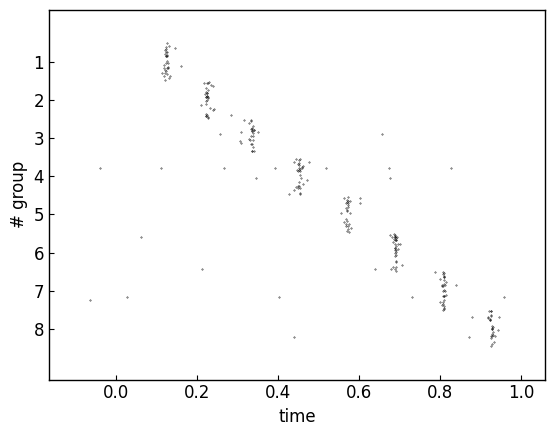

In [13]:
# print(x_rec.shape, t_rec.shape)
t_plot = np.linspace(t0, t1,512)
x_plot = resample_time_series(x_rec, t_rec, t_plot)

r_plot = resample_time_series(r_rec, t_rec, t_plot)
r_total = np.zeros_like(t_plot)
for t in t_rec.flatten():
    idx = np.argmin(t_plot < t)
    r_total[idx] += 1
r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))

neuron_idx = rng.choice(N*P, 32 * P)

# plot spike raster plot
print('plotting spike raster plot')
plt.scatter(
    t_rec[np.isin(k_rec[:, 0], neuron_idx), 0], k_rec[np.isin(k_rec[:, 0], neuron_idx), 0] / N + 0.5, c = 'k', s = 0.1
)
plt.gca().invert_yaxis()
plt.xlabel('time')
plt.ylabel('# group')
# plt.title('spike raster plot')
plt.yticks(np.arange(P) + 1.0)
plt.savefig(savedir + 'spike_raster.pdf', bbox_inches='tight')
plt.show()
# plt.imshow(r_plot.T, aspect='auto', cmap='viridis', extent=[t0, t1, P, 0], vmin = 0, vmax = 50)
# plt.xlabel('time')
# plt.ylabel('population index')
# plt.title('firing rate - simulation')
# plt.show()

# plt.imshow(x_plot.T, aspect='auto', cmap='viridis', extent=[t0, t1, P, 0], vmin = -50, vmax = 50)
# plt.xlabel('time')
# plt.ylabel('population index')
# plt.title('membrane potential - simulation')
# plt.show()



plotting firing rate


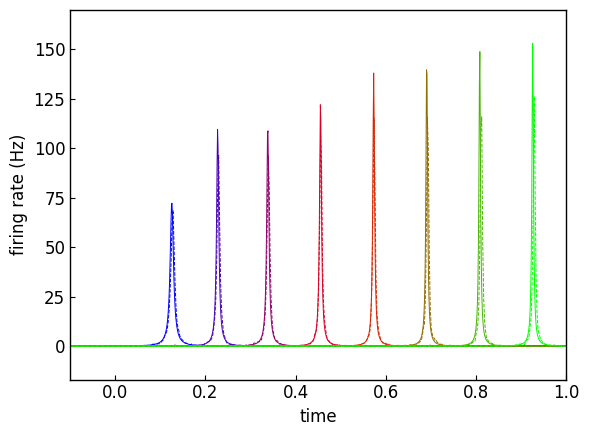

plotting membrane potential


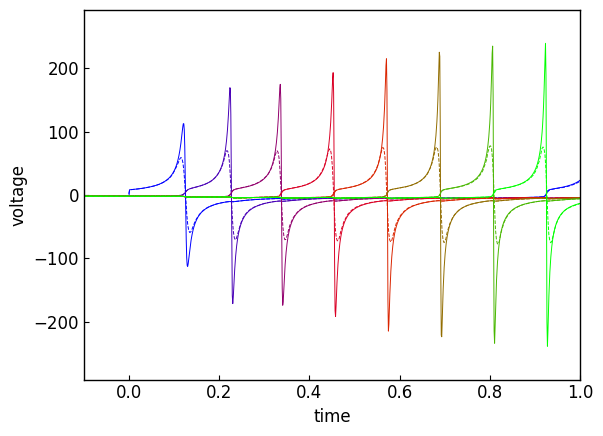

In [14]:
colors = plt.cm.brg(np.linspace(0, 1, P))

print('plotting firing rate')
# for p in range(P):
#     plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# for p in range(P):
#     plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p])
for p in range(P):
    if p == 0:
        plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p], label = 'FRE')
        plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p], label = 'Simulation')
    else:
        plt.plot(sol.t, sol.y[p], ls = '-', c = colors[p])
        plt.plot(t_plot, r_plot[:, p], ls = '--', c = colors[p])
# plt.legend()
plt.xlim(t0, t1)
plt.xlabel('time')
plt.ylabel('firing rate (Hz)')
plt.savefig(savedir + 'firing_rate.pdf', bbox_inches='tight')
plt.show()

print('plotting membrane potential')
for p in range(P):
    if p == 0:
        plt.plot(sol.t, sol.y[p+P], ls = '-', c = colors[p], label = 'FRE')
        plt.plot(t_plot, x_plot[:, p], ls = '--', c = colors[p], label = 'Simulation')    
    else:
        plt.plot(sol.t, sol.y[p+P], ls = '-', c = colors[p])
        plt.plot(t_plot, x_plot[:, p], ls = '--', c = colors[p])
# plt.legend()    
plt.xlabel('time')
plt.ylabel('voltage')
plt.savefig(savedir + 'membrane_potential.pdf', bbox_inches='tight')
plt.xlim(t0, t1)
plt.show()